In [152]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import geopandas as gpd


In [153]:
from model_prep import get_feature_name, model_transformer_train

In [154]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [155]:
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

C:\Users\bwils\anaconda3\envs\pumpitup\lib\site-packages\distributed\node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 64289 instead
  warnings.warn(


(<Scheduler: "tcp://127.0.0.1:64292" processes: 3 cores: 6>,
 {0: <Nanny: tcp://127.0.0.1:64310, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:64309, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:64315, threads: 2>})

In [156]:
model_data = pd.read_pickle('Data/model_data.pkl')

In [157]:
model_data.columns

Index(['id', 'class', 'amount_tsh', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'basin', 'subvillage', 'region_code',
       'district_code', 'ward', 'population', 'public_meeting',
       'scheme_management', 'scheme_name', 'permit', 'extraction_type',
       'management', 'management_group', 'payment_type', 'water_quality',
       'quantity', 'source', 'waterpoint_type', 'lga_Njombe', 'year', 'month',
       'years_old', 'popbins'],
      dtype='object')

In [158]:
model_data.drop(columns=['id', 'region_code'], inplace=True)

In [40]:
class2 = model_data.loc[model_data['class']=='functional'].sample(5000, replace=True)
class0 = model_data.loc[model_data['class']=='non functional'].sample(5000, replace=True)
class1 = model_data.loc[model_data['class']=='functional needs repair'].sample(5000, replace=True)
split_data = pd.concat([class0, class1, class2])

In [41]:
split_data['class'] = split_data['class'].map({'functional':2, 'non functional':0, 'functional needs repair':1})

In [177]:
num_cols = ['gps_height', 'population']
cat_cols = ['basin', #'region_code', 'district_code', 
            'extraction_type', 'payment_type', 'water_quality', 'quantity', 
            'source', 'management', 'management_group', 'waterpoint_type',  'funder', 'installer', 'subvillage', 
            'ward', 'scheme_management', 'scheme_name', 'popbins']

In [178]:
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore')
CT = ColumnTransformer(remainder='passthrough', transformers=[('scaler', scaler, num_cols),
                                              ('ohe', ohe, cat_cols)], verbose=True, sparse_threshold=0)

In [161]:
def prep_train(unprepped_values, class_col):
    train_X, test_X, train_y, test_y = train_test_split(unprepped_values.drop(columns=[class_col]), 
                                                        unprepped_values[class_col], test_size=0.25, random_state=42)
    train_Xct = CT.fit_transform(train_X)
    
    test_Xct = CT.transform(test_X)

    cols = get_feature_name(CT)
    train_Xf = pd.DataFrame(train_Xct, columns=cols)
    cols = get_feature_name(CT)
    test_Xf = pd.DataFrame(test_Xct, columns=cols)
    
    return train_Xf, train_y, test_Xf, test_y   

In [162]:
def prep_submit(unprepped_values):
    submit_X= unprepped_values
        
    submit_Xt = model_transformer_train(submit_X)
    submit_Xct = CT.transform(submit_Xt)

    cols = get_feature_name(CT)
    submit_Xf = pd.DataFrame(submit_Xct.todense(), columns=cols)
    
    return submit_Xf

In [42]:
train_Xf, train_y, test_Xf, test_y = prep_train(split_data, 'class')

[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.1s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


In [43]:
xgb = XGBClassifier(use_label_encoder=False)
params_xgb = {'max_depth':[1, 2, 5, 10, 16, 25], 'learning_rate':[.1, .2, .3, .4, .5, .6, .7, .8, .9],
             'min_split_loss':[.1, .5, 1, 5, 10, 25, 100], 'reg_lambda':[.1, .5, 1, 5, 10, 25], 
              'reg_alpha':[.1, .5, 1, 5, 10, 25]}#'n_estimators':[100],
rsearchxgb = RandomizedSearchCV(xgb, param_distributions=params_xgb, n_iter=3, cv=3, verbose=1)
pca = PCA(n_components=100)
train_Xf = pca.fit_transform(train_Xf)
with joblib.parallel_backend('dask'):
    rsearchxgb.fit(train_Xf, train_y)
rsearchxgb.cv_results_

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[16:00:46] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'mean_fit_time': array([364.84211047, 260.38066602, 503.835591  ]),
 'std_fit_time': array([37.79653409,  7.9460368 , 15.29504353]),
 'mean_score_time': array([0.02500534, 0.02366765, 0.04366668]),
 'std_score_time': array([0.01485127, 0.00634162, 0.0301347 ]),
 'param_reg_lambda': masked_array(data=[0.5, 1, 1],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_reg_alpha': masked_array(data=[10, 5, 0.5],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_split_loss': masked_array(data=[100, 100, 25],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[25, 10, 16],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.5, 0.7, 0.8],
              mask=[False, False, False],
        fill_value='?',
             dtype=ob

In [44]:
test_Xf = pca.transform(test_Xf)
rsearchxgb.score(test_Xf, test_y)

0.6368

In [ ]:
rf = RandomForestClassifier()
params_rf = {'criterion':['gini', 'entropy'], 'max_depth':[1, 3, 5, 7], 'max_leaf_nodes':[2, 4, 6, 10], 
          'min_samples_split':[.1, .2, .3, .4, .5, .6, .7, .8, .9], 'min_samples_leaf':[.1, .2, .3, .4, .5]}
rsearchrf = RandomizedSearchCV(rf, param_distributions=params_rf, n_inter=20, cv=5, verbose=1)
rsearchrf.fit(train_Xf, train_y)
rsearchrf.cv_results_

In [ ]:
rsearchrf.score(test_Xf, test_y)

In [166]:
data = model_data.copy()
data['class'] = data['class'].map({'functional':2, 'non functional':0, 'functional needs repair':1})
train_Xf, train_y, test_Xf, test_y = prep_train(data, 'class')

[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.6s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


In [167]:
data['class']

0        2
1        2
2        2
3        0
4        2
        ..
59395    2
59396    2
59397    2
59398    2
59399    2
Name: class, Length: 59400, dtype: int64

In [95]:
rf = RandomForestClassifier(n_estimators=250, verbose=True)#criterion='gini', max_depth=3, max_leaf_nodes=4, min_samples_split=.2, min_samples_leaf=.05,
pca = PCA(n_components=100)
train_Xfpca = pca.fit_transform(train_Xf)
with joblib.parallel_backend('dask'):
    rf.fit(train_Xfpca, train_y)
test_Xfpca = pca.transform(test_Xf)
rf.score(test_Xfpca, test_y)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    2.3s finished


0.7929292929292929

In [168]:
rf = RandomForestClassifier(n_estimators=500, verbose=True)#criterion='gini', max_depth=3, max_leaf_nodes=4, min_samples_split=.2, min_samples_leaf=.05,
pca = PCA(n_components=100)
train_Xfpca = pca.fit_transform(train_Xf)
with joblib.parallel_backend('dask'):
    rf.fit(train_Xfpca, train_y)
test_Xfpca = pca.transform(test_Xf)
rf.score(test_Xfpca, test_y)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    6.0s finished


0.7952188552188553

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    6.5s finished


<Figure size 2880x576 with 0 Axes>

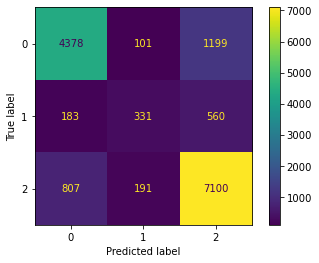

In [169]:
y_pred = rf.predict(test_Xfpca)
with joblib.parallel_backend('dask'):
    cm=confusion_matrix(test_y, y_pred, labels=rf.classes_)
    disp = ConfusionMatrixDisplay(cm, display_labels=rf.classes_)
plt.figure(figsize=(40,8))
disp.plot()

In [179]:
data = model_data.copy()
data['class'] = data['class'].map({'functional':2, 'non functional':0, 'functional needs repair':1})
train_Xf, train_y, test_Xf, test_y = prep_train(data, 'class')

[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.5s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


In [180]:
rf = RandomForestClassifier(n_estimators=300, verbose=True)#criterion='gini', max_depth=3, max_leaf_nodes=4, min_samples_split=.2, min_samples_leaf=.05,
pca = PCA(n_components=100)
train_Xfpca = pca.fit_transform(train_Xf)
with joblib.parallel_backend('dask'):
    rf.fit(train_Xfpca, train_y)
test_Xfpca = pca.transform(test_Xf)
rf.score(test_Xfpca, test_y)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    4.1s finished


0.7925925925925926

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.8s finished


<Figure size 2880x576 with 0 Axes>

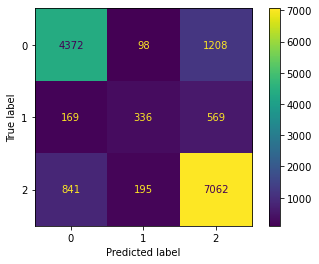

In [181]:
y_pred = rf.predict(test_Xfpca)
with joblib.parallel_backend('dask'):
    cm=confusion_matrix(test_y, y_pred, labels=rf.classes_)
    disp = ConfusionMatrixDisplay(cm, display_labels=rf.classes_)
plt.figure(figsize=(40,8))
disp.plot()

In [182]:
checker = test_Xf.copy()

In [183]:
checker.insert(0, value=y_pred, column='prediction')

In [184]:
t = test_y.copy().reset_index(drop=True)

In [185]:
checker.insert(0, value=t, column='class')

In [186]:
checker

,class,prediction,scaler__gps_height,scaler__population,ohe__x0_Internal,ohe__x0_Lake Nyasa,ohe__x0_Lake Rukwa,ohe__x0_Lake Tanganyika,ohe__x0_Lake Victoria,ohe__x0_Pangani,...,amount_tsh,longitude,latitude,district_code,public_meeting,permit,lga_Njombe,year,month,years_old
0,0,0,0.109742,-0.379567,0.0,0.0,0.0,1.0,0.0,0.0,...,2.613176,31.985658,-3.596360,5.0,1.0,1.0,0.0,2012.0,10.0,13.0
1,2,2,-0.175639,-0.379567,0.0,0.0,0.0,1.0,0.0,0.0,...,1.787919,32.832815,-4.944937,6.0,1.0,1.0,0.0,2012.0,11.0,13.0
2,2,2,0.926472,-0.065372,1.0,0.0,0.0,0.0,0.0,0.0,...,2.661905,35.488289,-4.242048,1.0,1.0,1.0,0.0,2013.0,2.0,5.0
3,0,2,1.834414,-0.379567,0.0,0.0,1.0,0.0,0.0,0.0,...,3.000000,33.140828,-9.059386,6.0,0.0,0.0,0.0,2011.0,8.0,12.0
4,2,2,-0.045465,0.119323,1.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,34.217077,-4.430529,1.0,1.0,1.0,0.0,2013.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,2,2,0.183304,-0.379567,0.0,0.0,0.0,0.0,1.0,0.0,...,3.403579,32.786407,-3.286384,3.0,1.0,1.0,0.0,2012.0,10.0,13.0
14846,0,0,-0.404360,-0.356215,0.0,0.0,0.0,0.0,0.0,0.0,...,2.000000,36.679082,-8.965459,4.0,1.0,1.0,0.0,2011.0,3.0,31.0
14847,1,2,-0.064354,0.681901,0.0,0.0,1.0,0.0,0.0,0.0,...,3.855504,31.246094,-6.360838,1.0,0.0,1.0,0.0,2011.0,7.0,3.0
14848,0,2,0.305678,-0.379567,1.0,0.0,0.0,0.0,0.0,0.0,...,1.796645,34.097419,-3.155770,2.0,1.0,0.0,0.0,2012.0,10.0,13.0


In [187]:
checker['correct']=checker['prediction']==checker['class']
checker['correct']

0         True
1         True
2         True
3        False
4         True
         ...  
14845     True
14846     True
14847    False
14848    False
14849     True
Name: correct, Length: 14850, dtype: bool

In [189]:
test_Xfpca
pd.DataFrame(rf.feature_importances_.reshape(1,-1), 
             columns=expdf.columns[:100]).T.rename(columns={0:'Importances'}).sort_values(by='Importances', 
                                                                           ascending=False).head(25)

,Importances
ohe__x1_8,0.035730
scaler__gps_height,0.030499
ohe__x1_2,0.025638
ohe__x0_Wami-Ruvu,0.022172
ohe__x1_14,0.020571
ohe__x0_Lake Tanganyika,0.019089
ohe__x1_21,0.018914
ohe__x1_12,0.013711
scaler__population,0.013097
ohe__x1_11,0.013053


In [148]:
pcacols = PCA()
pcacols.fit(train_Xf)
exp = pcacols.explained_variance_
exp
expdf = pd.DataFrame(exp.reshape(1,-1), columns=train_Xf.columns)
expdf.T.rename(columns={0:'var'}).sort_values('var', ascending=False)

,var
scaler__gps_height,1.039087e+02
scaler__population,1.447754e+01
ohe__x0_Internal,6.250422e+00
ohe__x0_Lake Nyasa,5.071451e+00
ohe__x0_Lake Rukwa,1.471009e+00
...,...
ohe__x17_1,6.554983e-31
ohe__x16_wanging'ombe water supply s,6.554983e-31
year,4.911722e-31
month,4.051318e-31


In [150]:
train_Xf

,scaler__gps_height,scaler__population,ohe__x0_Internal,ohe__x0_Lake Nyasa,ohe__x0_Lake Rukwa,ohe__x0_Lake Tanganyika,ohe__x0_Lake Victoria,ohe__x0_Pangani,ohe__x0_Rufiji,ohe__x0_Ruvuma-Southern_Coast,...,ohe__x17_9,amount_tsh,longitude,latitude,public_meeting,permit,lga_Njombe,year,month,years_old
0,-1.383165,-0.209732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.056703,38.123839,-6.087137,1.0,1.0,0.0,2011.0,3.0,39.0
1,0.322698,-0.379567,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,2.198999,31.000000,-1.000000,0.0,0.0,0.0,2013.0,2.0,14.0
2,0.196048,-0.379567,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,3.207379,33.312321,-2.814100,1.0,1.0,0.0,2011.0,8.0,12.0
3,0.698084,-0.330739,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.925946,34.783049,-4.842093,1.0,1.0,0.0,2013.0,1.0,3.0
4,-1.051745,-0.377444,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.000000,34.660944,-10.707331,0.0,1.0,0.0,2013.0,9.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44545,-1.388317,0.161782,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,3.000000,36.367112,-8.774761,1.0,1.0,0.0,2011.0,3.0,16.0
44546,1.043242,-0.305264,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.000000,34.531524,-9.769604,1.0,0.0,0.0,2011.0,3.0,23.0
44547,-1.882963,1.743370,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.606018,38.974416,-5.420823,0.0,0.0,0.0,2011.0,3.0,6.0
44548,0.399966,-0.379567,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,2.469591,34.316586,-3.107161,1.0,1.0,0.0,2012.0,10.0,13.0


In [57]:
from model_prep import Chi_sq_test

ImportError: cannot import name 'Chi_sq_test' from 'model_prep' (C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\__init__.py)

In [58]:
def Chi_sq_test(df, dependant, independant):
    #takes in the names of a dependant and independant variable (column), runs a chi squared test and then outputs 
    #a seaborn heatmap of the percent difference between the expected and actual values
    
    from scipy.stats import chi2_contingency
    from scipy.stats import chi2
    
    #create cotingency table
    count_table = df.groupby([dependant, independant])['id'].count().unstack()
    count_table.fillna(0, inplace=True)
    count_table = count_table.astype('int')
    
    #Chi Squared test is for only counts above 5, we are keeping the same ratio, but increasing min value to 5 in each column
    if count_table.isin(range(0,5)).any().any():
        for j in range(len(count_table.columns)):
            for i in range(len(count_table.index)):
                if count_table.iloc[i,j] < 1:
                    count_table.iloc[i,j] = 5
                    count_table.iloc[:,j] = count_table.iloc[:,j]*5
                elif count_table.iloc[i,j] <5:
                    count_table.iloc[:,j] = count_table.iloc[:,j]*(5/count_table.iloc[i,j])
    
    stat, p, dof, expected = chi2_contingency(count_table)
    
    #print test information
    print('P-Value = {}'.format(p))
    print('Chi Statistic = {}'.format(stat))
    print('Degrees of Freedom = {}'.format(dof))
    
    #caluclate and print heatmap
    plt.figure(figsize=(12,6))
    sns.heatmap(((count_table - expected) / count_table *100), annot=True, vmax=100, vmin=-100, fmt='.1f', 
                annot_kws={'rotation': 90}, cmap='viridis')
    plt.title('Percent Difference of Expected vs. Actual Classes per {}'.format(str.title(independant)))
    plt.show()

In [191]:
Chi_sq_test(checker, 'correct', 'popbins')

KeyError: 'popbins'